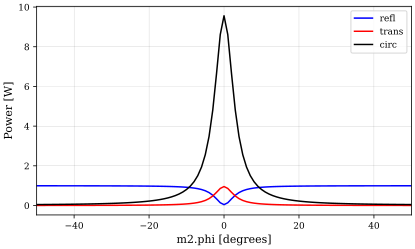

In [1]:
### Task 1: Plot the PDH error signal for the cavity
#Plot the photodiode output as a function of the tuning of mirror M2 in the range -50 to +50 degrees.
import finesse

finesse.configure(plotting=True)

model = finesse.Model()
model.parse(
    """
    laser l1 P=1 f=0
    space s1 portA=l1.p1 portB=mod1.p1
    modulator mod1 80M 0.3 order=3
    space s2 portA=mod1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1

    pd refl node=m1.p1.o
    pd trans node=m2.p2.o
    pd circ node=m1.p2.o
    xaxis(m2.phi, lin, -50, 50, 100)#photodiode output as a function of the tuning of mirror M2 in the range -50 to +50 degrees.
    """
)
out=model.run()
model.run().plot();

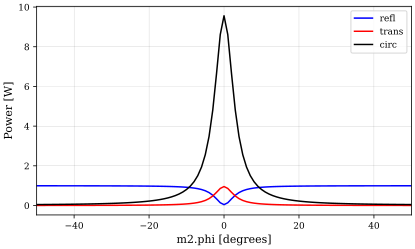

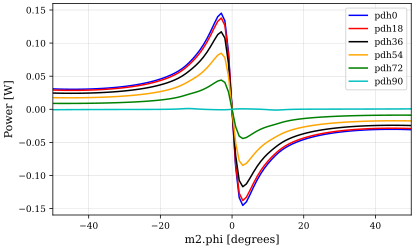

In [4]:
#Optimising the demodulation phase
import finesse

finesse.configure(plotting=True)

model = finesse.Model()
model.parse(
    """
    laser l1 P=1 f=0
    space s1 portA=l1.p1 portB=mod1.p1
    modulator mod1 80M 0.3 order=3
    space s2 portA=mod1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1

    pd refl node=m1.p1.o
    pd trans node=m2.p2.o
    pd circ node=m1.p2.o
    """
)
import numpy as np

for phase in np.linspace(0, 90, endpoint=True, num=6):
    model.parse(f"pd1 pdh{phase:.0f} node=m1.p1.o f=mod1.f phase={phase:.0f}")
    model.parse("xaxis(m2.phi, lin, -50, 50, 100)")
model.run().plot();

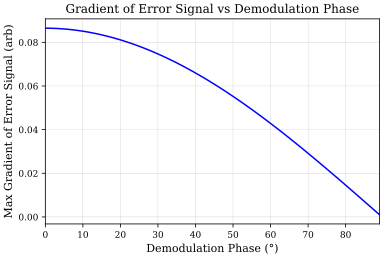

In [5]:
import finesse
import numpy as np
from matplotlib import pyplot as plt

finesse.configure(plotting=True)

# Define the Finesse model
model = finesse.Model()
model.parse(
    """
    laser l1 P=1 f=0
    space s1 portA=l1.p1 portB=mod1.p1
    modulator mod1 80M 0.3 order=3
    space s2 portA=mod1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1

   pd refl node=m1.p1.o
    pd trans node=m2.p2.o
    pd circ node=m1.p2.o
    """
)

# Function to remove old demodulation photodiodes
def remove_demod_pds(verbose=True):
    elements_to_remove = [el for el in model.elements if el.startswith('pdh')]
    for el in elements_to_remove:
        model.remove(el)
        if verbose: 
            print(f'Removed {el}')

# Remove the old detectors
remove_demod_pds()

# Create an array of demodulation phases
phases = np.arange(0, 90, 1)  # Adjust range and step size as needed

# List to store results
results = []

# Loop through phases and run the model
for phase in phases:
    model.parse(f"pd1 pdh{phase:.0f} node=m1.p1.o f=mod1.f phase={phase:.0f}")
    model.parse("xaxis(m2.phi, lin, -1, 1, 2)")  # Sweep M2 tuning
    out = model.run()
    results.append((phase, out[f'pdh{phase:.0f}']))

# Calculate the gradient of the error signal
gradients = []
for phase, data in results:
    gradient = np.gradient(data)  # Compute gradient
    gradients.append(np.max(np.abs(gradient)))  # Take the maximum absolute gradient

# Plot the gradients 
plt.plot(phases, gradients)
plt.xlabel('Demodulation Phase (°)')
plt.ylabel('Max Gradient of Error Signal (arb)')
plt.title('Gradient of Error Signal vs Demodulation Phase')
plt.show()
